### **`Dependencies`**

In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
import random
import warnings

import pandas as pd
import plotly.express as px

from plotly.graph_objects import Figure

from src.data import fetch_data, transform_data
from src.inference import generate_multi_step_forecast
from src.model import load_model
from src.monitor import backtest_model, evaluate_model
from src.utils import compute_metrics, plot_time_series_splits, split_data

warnings.filterwarnings("ignore")

In [2]:
# set the pd.DataFrame and pd.Series display options
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 50)

### **`Feature pipeline`**

In [4]:
# raw data -> pre-processed and validated data -> features and targets
df: pd.DataFrame = fetch_data().pipe(transform_data)
df

2025-02-22 08:41:39.966 | INFO     | src.data:fetch_data:40 - Fetching raw data from the 'postgres' database's 'time_series.energy_demand' table.
2025-02-22 08:41:40.926 | INFO     | src.data:fetch_data:118 - The raw data has been pre-processed and validated.
2025-02-22 08:41:40.927 | INFO     | src.data:transform_data:150 - Transforming the pre-processed data into features and targets.


company_id       timestamp_utc  day_of_week  time_of_day  hour  \
0           aep 2025-02-09 16:00:00            7            1    16   
1           aep 2025-02-09 17:00:00            7            2    17   
2           aep 2025-02-09 18:00:00            7            2    18   
3           aep 2025-02-09 19:00:00            7            2    19   
4           aep 2025-02-09 20:00:00            7            2    20   
...         ...                 ...          ...          ...   ...   
3438       pjmw 2025-02-22 12:00:00            6            1    12   
3439       pjmw 2025-02-22 13:00:00            6            1    13   
3440       pjmw 2025-02-22 14:00:00            6            1    14   
3441       pjmw 2025-02-22 15:00:00            6            1    15   
3442       pjmw 2025-02-22 16:00:00            6            1    16   

      mean_24_lags  std_24_lags  mean_20_lags  std_20_lags  mean_16_lags  \
0     16164.375000  1176.316647      16164.85  1235.837209    15973.0625   
1     16179.041667  1167.059645      16074.30  1202.617763    16002.3750   
2     16193.708333  1160.228781      16001.15  1167.744036    16078.2500   
3     16209.500000  1166.996405      15997.35  1164.630471    16240.1250   
4     16219.875000  1178.901121      16077.45  1220.526223    16444.8125   
...            ...          ...           ...          ...           ...   
3438   5199.000000   429.840112       5143.55   451.538012     5090.0000   
3439   5201.875000   432.429066       5153.40   459.730745     5105.3125   
3440   5204.958333   434.548689       5160.30   464.448524     5106.5625   
3441   5207.625000   436.540133       5170.95   471.107930     5102.0625   
3442   5211.083333   438.693606       5181.75   476.569747     5117.8750   

      std_16_lags  mean_12_lags  std_12_lags  mean_8_lags  std_8_lags  \
0     1287.079095  16428.083333  1145.006428    16891.250  774.048125   
1     1272.832268  16536.333333   979.024592    16591.875  730.880377   
2     1220.618941  16629.166667   834.169247    16353.250  597.457889   
3     1134.824149  16728.666667   779.423136    16295.375  504.259269   
4     1065.161723  16759.166667   808.839217    16368.500  649.755998   
...           ...           ...          ...          ...         ...   
3438   492.378445   4974.250000   514.970983     5190.625  489.853021   
3439   505.047947   5041.416667   542.164594     5337.125  398.280747   
3440   506.129360   5120.333333   537.640017     5456.500  252.166612   
3441   501.540356   5214.916667   500.852992     5542.875   72.866684   
3442   510.722348   5310.000000   429.266181     5560.125   32.117808   

      mean_4_lags  std_4_lags   lag_24   lag_23   lag_22   lag_21   lag_20  \
0        16242.00  284.950288  15287.0  15491.0  16490.0  17380.0  17450.0   
1        16008.50  305.258907  15491.0  16490.0  17380.0  17450.0  17306.0   
2        15878.00  192.981864  16490.0  17380.0  17450.0  17306.0  16945.0   
3        16069.25  546.633561  17380.0  17450.0  17306.0  16945.0  16027.0   
4        16495.00  928.021551  17450.0  17306.0  16945.0  16027.0  15170.0   
...           ...         ...      ...      ...      ...      ...      ...   
3438      5571.50   17.540429   5538.0   5452.0   5486.0   5429.0   5410.0   
3439      5578.00   25.324560   5452.0   5486.0   5429.0   5410.0   5388.0   
3440      5567.75   36.908671   5486.0   5429.0   5410.0   5388.0   5337.0   
3441      5568.00   36.742346   5429.0   5410.0   5388.0   5337.0   5296.0   
3442      5548.75   41.883768   5410.0   5388.0   5337.0   5296.0   5362.0   

       lag_19   lag_18   lag_17   lag_16   lag_15   lag_14   lag_13   lag_12  \
0     17306.0  16945.0  16027.0  15170.0  14629.0  14279.0  14354.0  14340.0   
1     16945.0  16027.0  15170.0  14629.0  14279.0  14354.0  14340.0  14729.0   
2     16027.0  15170.0  14629.0  14279.0  14354.0  14340.0  14729.0  15675.0   
3     15170.0  14629.0  14279.0  14354.0  14340.0  14729.0  15675.0  17263.0   
4     14629.0  14279.0  1

In [5]:
# line plot of each company ID's hourly energy demand
fig: Figure = px.line(
    data_frame=df,
    x="timestamp_utc",
    y="energy_demand_mw",
    color="company_id",
    labels={
        "timestamp_utc": "Timestamp (UTC)",
        "energy_demand_mw": "Energy Demand (MW)",
        "company_id": "Company ID"
    },
    markers=True,
    title="Hourly Energy Demand",
    template="plotly_dark"
)
fig.show()

### **`Training pipeline`**

2025-02-22 09:31:57.877 | INFO     | src.data:fetch_data:40 - Fetching raw data from the 'postgres' database's 'time_series.energy_demand' table.
2025-02-22 09:31:58.715 | INFO     | src.data:fetch_data:118 - The raw data has been pre-processed and validated.
2025-02-22 09:31:58.717 | INFO     | src.data:transform_data:150 - Transforming the pre-processed data into features and targets.


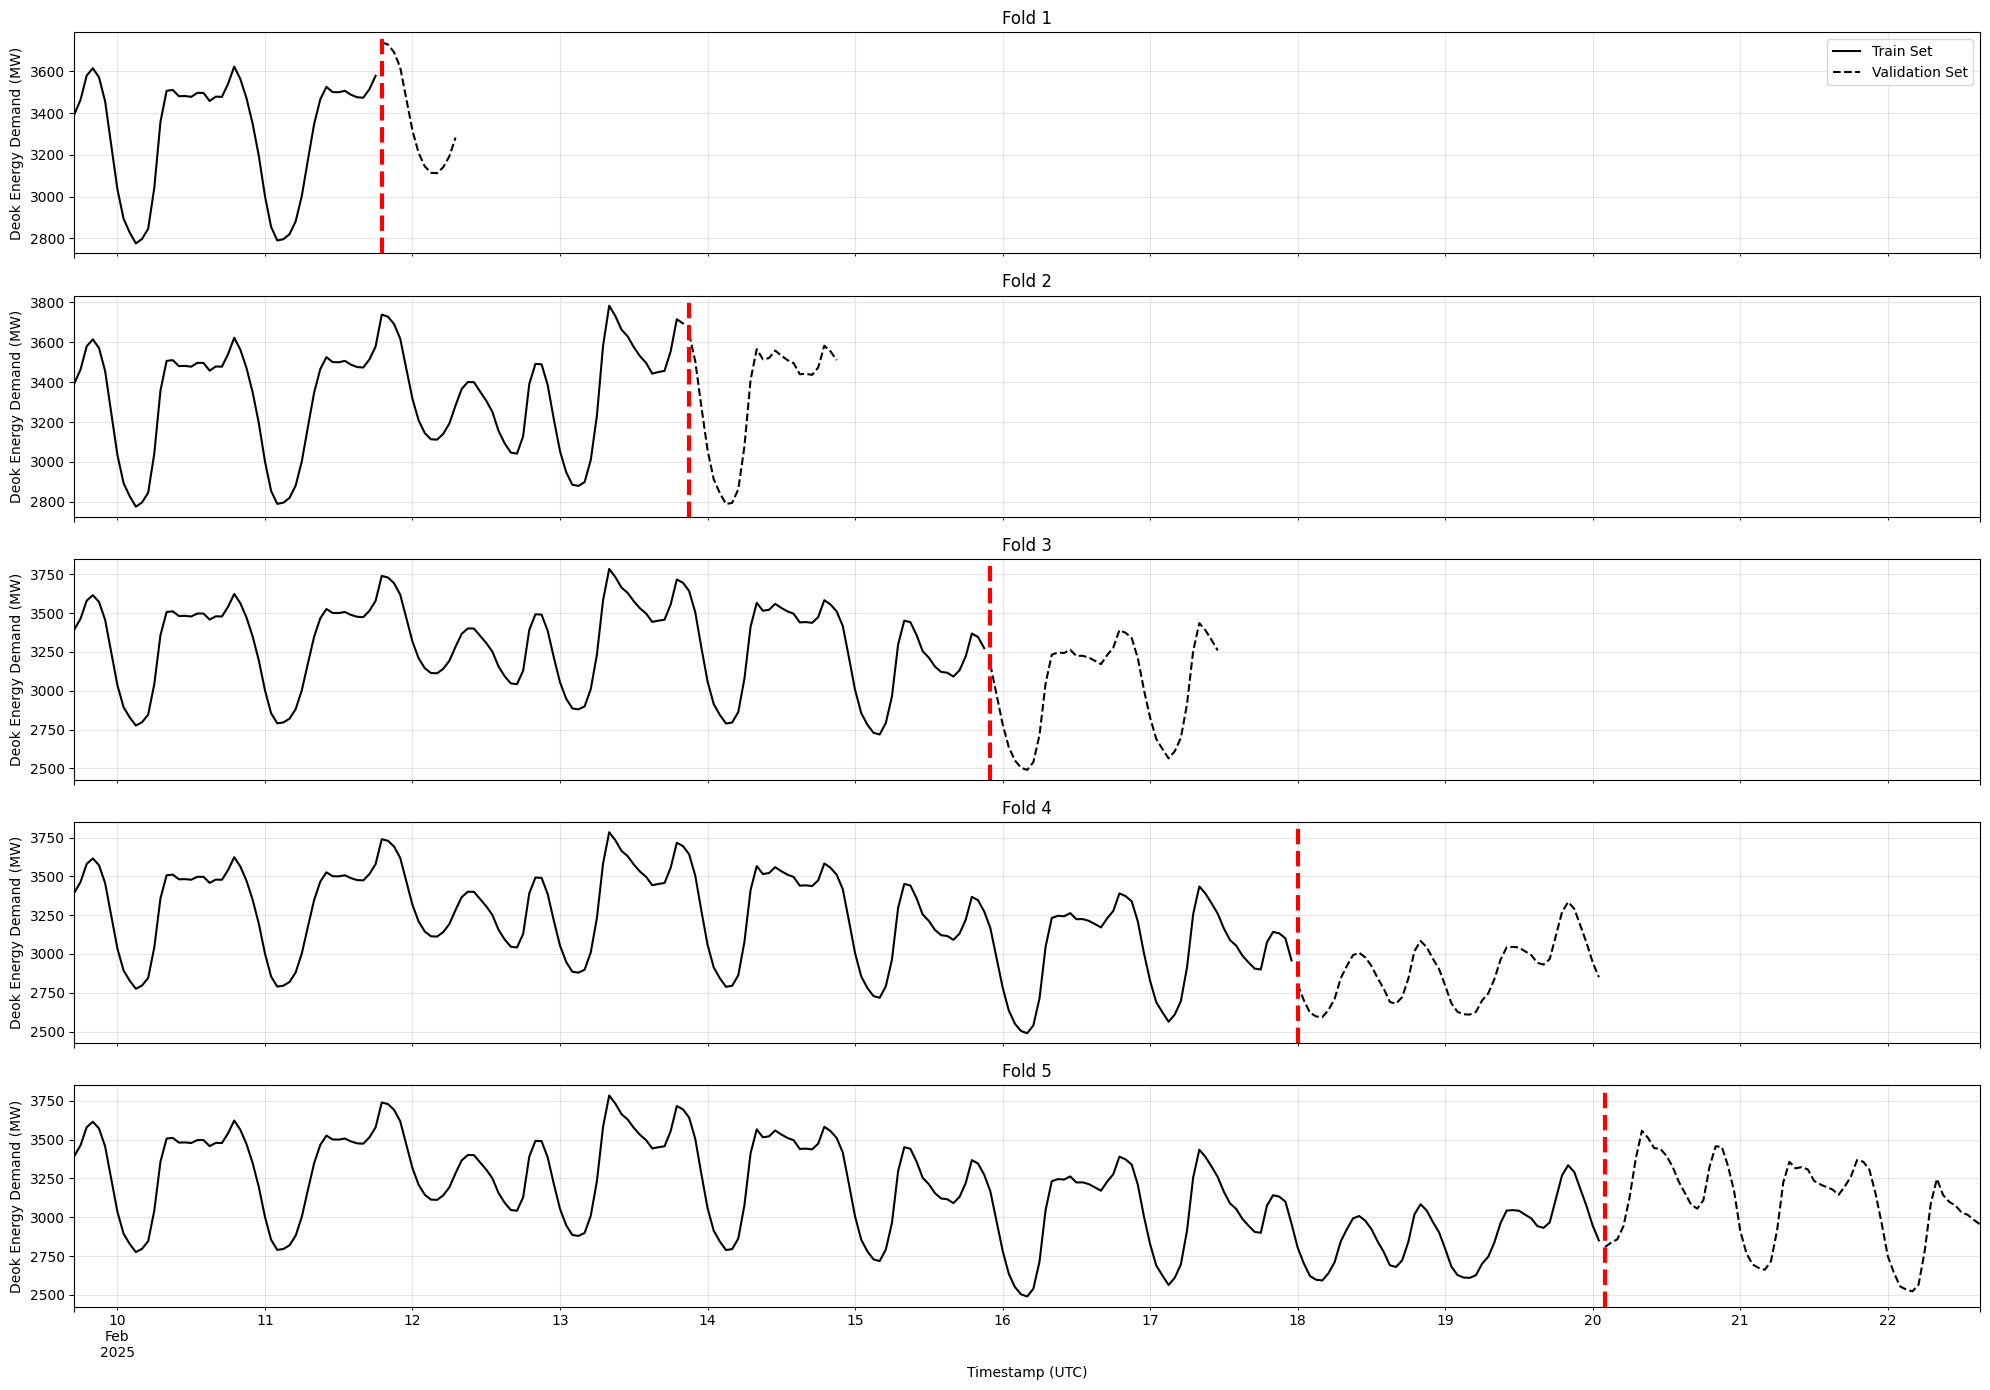

In [16]:
# plot the K-fold walk-forward validation for a randomly selected company ID
df: pd.DataFrame = fetch_data().pipe(transform_data)
df.pipe(
    plot_time_series_splits,
    random.choice(df["company_id"].unique())
)

In [17]:
# load the current forecasting model
load_model()

LGBMRegressor(learning_rate=0.17326859672437625, max_depth=8,
              min_data_in_leaf=21, n_estimators=148, num_leaves=43,
              verbosity=-1)

In [18]:
# backtest the current forecasting model
_, response = backtest_model(random.choice(range(4, 25)))
response

2025-02-22 09:32:19.206 | INFO     | src.data:fetch_data:40 - Fetching raw data from the 'postgres' database's 'time_series.energy_demand' table.
2025-02-22 09:32:20.053 | INFO     | src.data:fetch_data:118 - The raw data has been pre-processed and validated.
2025-02-22 09:32:20.055 | INFO     | src.data:transform_data:150 - Transforming the pre-processed data into features and targets.
2025-02-22 09:32:20.458 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 1 hour forecast.
2025-02-22 09:32:20.628 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 2 hour forecast.
2025-02-22 09:32:20.833 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 3 hour forecast.
2025-02-22 09:32:21.085 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 4 hour forecast.
2025-02-22 09:32:21.385 | INFO     | src.inference:generate_multi_step_forecast:15

'pass'

In [ ]:
# evaluate the current forecasting model
# NOTE: execute this cell if the above cell outputs 'fail'
evaluate_model()

### **`Inference pipeline`**

In [19]:
test_size: int = 12
df_train, df_test = fetch_data().pipe(transform_data).pipe(split_data, test_size)

2025-02-22 09:35:49.835 | INFO     | src.data:fetch_data:40 - Fetching raw data from the 'postgres' database's 'time_series.energy_demand' table.
2025-02-22 09:35:50.661 | INFO     | src.data:fetch_data:118 - The raw data has been pre-processed and validated.
2025-02-22 09:35:50.662 | INFO     | src.data:transform_data:150 - Transforming the pre-processed data into features and targets.


In [20]:
# a dictionary to map each company ID to its last known value, i.e., the train set's last value
naive_forecaster: dict[str, float] = {
    company_id: df_train.query(f"company_id == '{company_id}'").iloc[-1]["energy_demand_mw"]
    for company_id in df_train["company_id"].unique()
}
naive_forecaster

{'aep': 12530.0,
 'comed': 10069.0,
 'dayton': 1589.0,
 'deok': 2565.0,
 'dom': 7952.0,
 'duq': 1384.0,
 'ekpc': 1115.0,
 'fe': 7152.0,
 'ni': 8442.0,
 'pjme': 23336.0,
 'pjmw': 4571.0}

In [21]:
# a pd.DataFrame that contains the target, the naive forecast, and the model's forecast
df_forecast: pd.DataFrame = (
    df_test
    .assign(naive_forecast=df_test["company_id"].map(naive_forecaster))
    .merge(
        df_train.pipe(generate_multi_step_forecast, forecast_horizon=test_size),
        how="inner",
        on=["company_id", "timestamp_utc"]
    )
    .rename(columns={"energy_demand_mw": "target", "forecast": "model_forecast"})
    [[
        "company_id",
        "timestamp_utc",
        "target",
        "naive_forecast",
        "model_forecast"
    ]]
)
df_forecast

2025-02-22 09:36:32.866 | INFO     | src.inference:generate_multi_step_forecast:151 - Generating each company ID's 12 hour forecast.


company_id       timestamp_utc   target  naive_forecast  model_forecast
0          aep 2025-02-22 06:00:00  13369.0         12530.0         13233.0
1          aep 2025-02-22 07:00:00  14984.0         12530.0         14103.0
2          aep 2025-02-22 08:00:00  15915.0         12530.0         15043.0
3          aep 2025-02-22 09:00:00  15966.0         12530.0         15267.0
4          aep 2025-02-22 10:00:00  16017.0         12530.0         15259.0
..         ...                 ...      ...             ...             ...
127       pjmw 2025-02-22 13:00:00   5526.0          4571.0          5580.0
128       pjmw 2025-02-22 14:00:00   5550.0          4571.0          5539.0
129       pjmw 2025-02-22 15:00:00   5512.0          4571.0          5488.0
130       pjmw 2025-02-22 16:00:00   5489.0          4571.0          5511.0
131       pjmw 2025-02-22 17:00:00   5505.0          4571.0          5526.0

[132 rows x 5 columns]

In [22]:
# compare the naive forecast to the model's forecast
y: pd.Series = df_forecast["target"]
naive_metric: float = compute_metrics(y, df_forecast["naive_forecast"]).get("r_squared")
model_metric: float = compute_metrics(y, df_forecast["model_forecast"]).get("r_squared")
print(f"{test_size}-Hour Forecast\nNaive R²: {naive_metric}\nModel R²: {model_metric}")

12-Hour Forecast
Naive R²: 0.8568
Model R²: 0.9848


In [23]:
# plot the target, the naive forecast, and the model's forecast for each company ID
figs: list[Figure] = [
    px.line(
        (
            df_forecast
            .query(f"company_id == '{company_id}'")
            .rename(columns={
                "target": "Target",
                "model_forecast": "Model Forecast",
                "naive_forecast": "Naive Forecast"
            })
        ),
        x="timestamp_utc",
        y=["Target", "Model Forecast", "Naive Forecast"],
        color_discrete_sequence=["green", "blue", "red"],
        labels={
            "timestamp_utc": "Timestamp (UTC)",
            "value": "Energy Demand (MW)",
            "variable": "Company ID"
        },
        markers=True,
        title=f"{company_id.title()} Hourly Energy Demand",
        template="plotly_dark"
    )
    for company_id in sorted(df_forecast["company_id"].unique())
]
_ = [fig.show() for fig in figs]

In [ ]:
# a class that encapsulates the energy demand forecasting pipeline
class ForecastingPipeline:
    def __init__(self, forecast_horizon: int):
        self.forecast_horizon: int = forecast_horizon
    
    def __str__(self):
        return f"{self.forecast_horizon}-hour forecast"

    def run(self) -> pd.DataFrame:
        return (
            fetch_data()
            .pipe(transform_data)
            .pipe(generate_multi_step_forecast, self.forecast_horizon)
        )

# instantiate an object of tyep, 'ForecastingPipeline'
fp: ForecastingPipeline = ForecastingPipeline(test_size)
display(
    fp.forecast_horizon, fp.__str__(), fp.run()
)